# Calculate Shortest Path and Generate OD Matrx
This notebook 
* attribute farms to road network nodes
* calculate all-pair shortest paths between farms and all potential digester locations
* save the OD matrix (C_ij) as dictionary {p0: {f0: distance, f1: distance}...}

In [1]:
from cflp_function import store_data_to_pickle
import matplotlib.pyplot as plt
import networkx as nx
import osmnx as ox
import geopandas as gpd
import pandas as pd
from shapely.ops import nearest_points

In [2]:
%matplotlib inline

## 1. Farms to Nodes (QGIS)
Inputs:
* n - road network nodes (GeoDataFrame)
* farm - farm location points (GeoDataFrame)
* polygon_gdf - potential digester location polygons (GeoDataFrame)

In [3]:
n = gpd.read_file(r"./osm_network/G_n.shp")
n.head()

,osmid,y,x,lon,lat,highway,geometry
0,0,6.863327e+06,732329.118328,6.578624,52.348177,NaN,POINT (732329.118 6863326.894)
1,1,6.862993e+06,732029.301544,6.575931,52.346343,NaN,POINT (732029.302 6862992.539)
2,2,6.863769e+06,732826.404757,NaN,NaN,NaN,POINT (732826.405 6863768.536)
3,3,6.863381e+06,733531.413357,6.589425,52.348473,NaN,POINT (733531.413 6863380.689)
4,4,6.865492e+06,731879.617087,NaN,NaN,NaN,POINT (731879.617 6865492.254)


In [4]:
farm = gpd.read_file("./farm_new.shp")

In [5]:
print(n.crs, farm.crs)

EPSG:3857 EPSG:4326


In [6]:
n = n.to_crs('EPSG:28992')
farm = farm.to_crs('EPSG:28992')

In [7]:
polygon_gdf = gpd.read_file("./raster/suitable_polygons_complete_gdf.shp")
polygon_gdf.head()

,Label,geometry
0,1,"POLYGON ((235429.672 490648.031, 235439.672 49..."
1,2,"MULTIPOLYGON (((257649.672 490228.031, 257659...."
2,3,"MULTIPOLYGON (((266229.672 489098.031, 266239...."
3,4,"POLYGON ((264949.672 488218.031, 264969.672 48..."
4,5,"POLYGON ((241369.672 487388.031, 241399.672 48..."


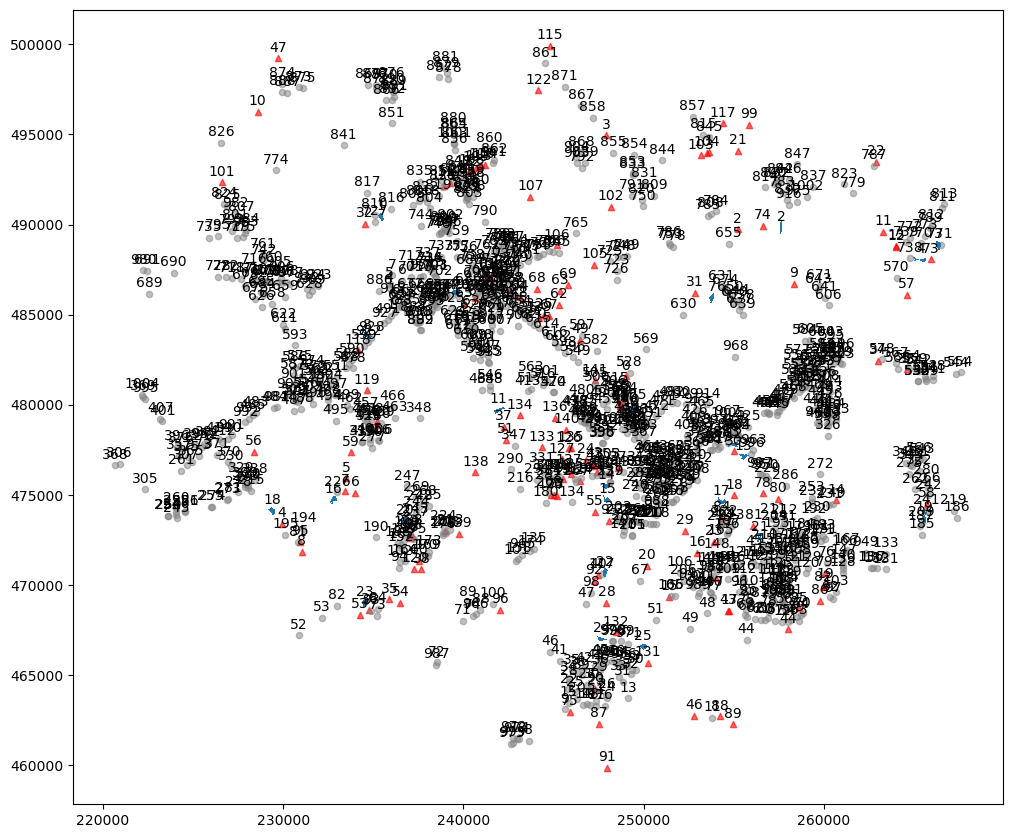

In [8]:
fig, ax = plt.subplots(figsize=(12, 12))
farm.plot(ax=ax, markersize=20, marker='^', color='red', alpha = 0.6)
n.plot(ax=ax, markersize=20, color='grey', alpha=0.5)
polygon_gdf.plot(ax=ax)
for x, y, idx in zip(farm.geometry.x, farm.geometry.y, farm.index.values):
    ax.annotate(idx, (x, y), textcoords='offset points', xytext=(0,5), ha='center')
# Annotate the points with their 'osmid' values
for x, y, osmid in zip(n.geometry.x, n.geometry.y, n['osmid']):
    ax.annotate(osmid, (x, y), textcoords="offset points", xytext=(0, 5), ha='center')
for x, y, l in zip(polygon_gdf.centroid.x, polygon_gdf.centroid.y, polygon_gdf['Label']):
    ax.annotate(l, (x, y), textcoords="offset points", xytext=(0, 5), ha='center')
plt.show()

In [9]:
# Find the nearest node for each farm
farm['closest_osmid'] = farm['geometry'].apply(
    lambda location: n.loc[n['geometry'] == nearest_points(location, n.unary_union)[1], 'osmid'].iloc[0]
)

In [10]:
polygon_gdf['centroid'] = polygon_gdf['geometry'].centroid

In [11]:
# Find the nearest node in n for each centroid
polygon_gdf['closest_osmid'] = polygon_gdf['centroid'].apply(
    lambda centroid: n.loc[n['geometry'] == nearest_points(centroid, n.unary_union)[1], 'osmid'].iloc[0]
    # lambda centroid: n.loc[nearest_points(centroid, n.unary_union)[1].x, 'osmid']
)

In [12]:
polygon_gdf


,Label,geometry,centroid,closest_osmid
0,1,"POLYGON ((235429.672 490648.031, 235439.672 49...",POINT (235441.161 490416.789),810
1,2,"MULTIPOLYGON (((257649.672 490228.031, 257659....",POINT (257620.084 489824.158),916
2,3,"MULTIPOLYGON (((266229.672 489098.031, 266239....",POINT (266347.784 488859.206),771
3,4,"POLYGON ((264949.672 488218.031, 264969.672 48...",POINT (265352.178 488051.133),738
4,5,"POLYGON ((241369.672 487388.031, 241399.672 48...",POINT (241377.360 487188.678),701
5,6,"MULTIPOLYGON (((239749.672 486498.031, 239769....",POINT (239596.031 486232.474),679
6,7,"MULTIPOLYGON (((253909.672 486208.031, 253929....",POINT (253786.820 485935.308),674
7,8,"MULTIPOLYGON (((234509.672 484028.031, 234539....",POINT (234693.749 483827.158),928
8,9,"POLYGON ((248909.672 480668.031, 249009.672 48...",POINT (248922.164 480489.694),504
9,10,"MULTIPOLYGON (((249359.672 480058.031, 249369....",POINT (249301.245 479691.713),925


## Plant for test

In [26]:
potential_plant_location = pd.read_csv('./farm_cluster_mock_5.csv')
potential_plant_location.head()

,x,y,count
0,6.870686,52.215190,25
1,6.554937,52.254895,25
2,6.730518,52.252885,42
3,6.914234,52.387401,18
4,6.664105,52.392622,32


In [27]:
nearest_neighbor = pd.read_csv('./osm_network/nearest_neighbor.csv')
nearest_neighbor.head()

,InputID,TargetID,Distance
0,507920,528,286.673776
1,507950,845,811.058871
2,507953,655,949.973658
3,507962,855,1048.825422
4,507964,195,662.103623


Here I should be loading set P from another file, I meant the file that has the indices of nodes representing the potential digester location

In [28]:
nearest_neighbor_p = pd.read_csv('./osm_network/nearest_neighbor_p.csv')
nearest_neighbor_p.head()

,InputID,TargetID,Distance
0,6.870686,125,332.611924
1,6.554937,190,2133.896966
2,6.730518,134,702.733217
3,6.914234,975,1375.746295
4,6.664105,790,728.068584


In [29]:
nearest_neighbor = nearest_neighbor.rename(columns={"TargetID": "osmid"})

In [30]:
merged_df = pd.merge(farm, nearest_neighbor, how='left', left_on="IND_OBJ_NA", right_on='InputID')
merged_df.head()

,IND_OBJ_KE,IND_WAARDE,IND_WAARD0,IND_OBJ_AA,IND_OBJ_NA,IND_OBJ_BE,IND_OBJ_GR,IND_PERIOD,IND_THEMA,IND_CULT_D,OBJECTID,geometry,closest_osmid,InputID,osmid,Distance
0,"driebeukig gebouw, ankerbalkgebint, stallen aa...",Rijksbeschermd,NaN,Ja,507920,hallehuisgroep (hallehuis - dwarshuistype),boerderijtypen,moderne tijd,landbouw,Gebouwd erfgoed,557.0,POINT (249005.834 481581.282),528,507920,528,286.673776
1,"driebeukig gebouw, ankerbalkgebint, stallen aa...",Rijksbeschermd,NaN,Ja,507950,hallehuisgroep (hallehuis - dwarshuistype),boerderijtypen,moderne tijd,landbouw,Gebouwd erfgoed,558.0,POINT (253627.289 494018.879),845,507950,845,811.058871
2,"driebeukig gebouw, ankerbalkgebint, stallen aa...",Rijksbeschermd,NaN,Ja,507953,hallehuisgroep (hallehuis - dwarshuistype),boerderijtypen,moderne tijd,landbouw,Gebouwd erfgoed,559.0,POINT (255218.991 489726.126),655,507953,655,949.973658
3,"driebeukig gebouw, ankerbalkgebint, stallen aa...",Rijksbeschermd,NaN,Ja,507962,hallehuisgroep (hallehuisboerderij),boerderijtypen,moderne tijd,landbouw,Gebouwd erfgoed,560.0,POINT (247910.770 494942.486),855,507962,855,1048.825422
4,"driebeukig gebouw, ankerbalkgebint, stallen aa...",Rijksbeschermd,NaN,Ja,507964,hallehuisgroep (t-huisboerderij),boerderijtypen,moderne tijd,landbouw,Gebouwd erfgoed,561.0,POINT (229912.783 473407.568),195,507964,195,662.103623


In [31]:
potential_plant_location['osmid'] = nearest_neighbor_p['TargetID']

## 2. Calculate OD Matrix
Inputs:
* Road network with farm information at nodes 
* Set of potential digester locations 

In [19]:
g = ox.load_graphml('./osm_network/G.graphml') 

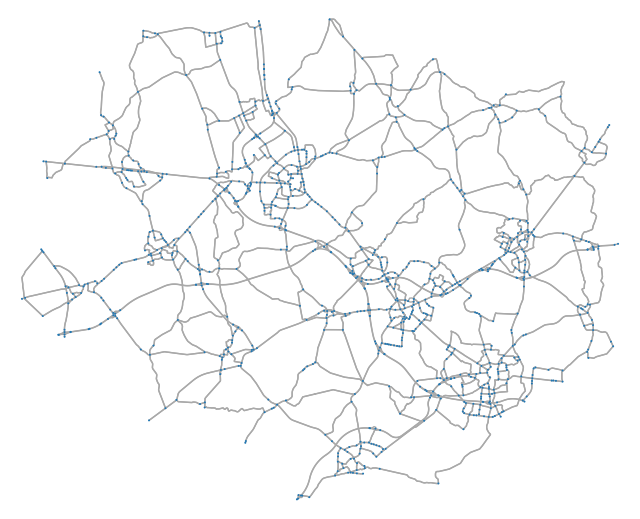

In [20]:
fig, ax = ox.plot_graph(g, node_size=2, node_color='tab:blue', edge_linewidth=1, edge_color= 'darkgray', figsize=(8,8), bgcolor='white')

In [21]:
# n, e = ox.graph_to_gdfs(g)

In [32]:
orig = farm['closest_osmid'].unique().tolist()
print(orig)

[528, 845, 655, 855, 195, 226, 81, 643, 888, 739, 249, 105, 144, 69, 222, 103, 67, 787, 165, 321, 620, 354, 340, 98, 218, 383, 630, 727, 564, 578, 84, 93, 347, 170, 486, 117, 333, 54, 150, 11, 874, 597, 208, 203, 330, 570, 241, 313, 701, 615, 745, 654, 679, 673, 670, 732, 771, 916, 9, 263, 229, 76, 286, 211, 92, 942, 64, 17, 23, 16, 319, 100, 198, 459, 824, 791, 725, 961, 959, 828, 861, 599, 457, 164, 836, 871, 310, 318, 429, 682, 50, 998, 331, 413, 438, 290, 213, 442, 505]


In [37]:
# Plant for test
dest = potential_plant_location['osmid'].unique().tolist()

In [23]:
# dest = polygon_gdf['closest_osmid'].unique().tolist()
# print(dest)

[810, 916, 771, 738, 701, 679, 674, 928, 504, 925, 388, 383, 996, 337, 226, 222, 195, 209, 243, 210, 117, 93, 970, 971]


In [35]:
# Initialize an empty OD matrix
od_matrix = {}

In [38]:
# Calculate shortest path between all pair orig (farm) and dest (potential location)
for origin in orig:
    od_matrix[origin] = {}
    for destination in dest:
        distance = nx.shortest_path_length(g, origin, destination, weight='length')
        od_matrix[origin][destination] = distance/1000 # convert from m to km
# {orig:{dest:distance, dest:distance....}}

In [39]:
# Initialize an empty nested dictionary
new_nested_dict = {}

# Create a new nested dictionary with DataFrame index as keys
for idx, row in farm.iterrows():
    osmid_value = row['closest_osmid']
    if osmid_value in od_matrix:
        new_nested_dict[idx] = od_matrix[osmid_value]

# {farm1:{dest:distance, dest:distance....}} # some nodes are the closest for more than 1 farms, so now we make sure the dictionary is with key of all farms and each take the 
# associated distances (i.e. some farms will have the same od to all dest)

In [40]:
for key, value in new_nested_dict.items():
    print(f"{key}:{value}")

0:{125: 24.38013393505244, 190: 27.69527117195013, 134: 15.593838742840918, 975: 23.62720894186127, 790: 20.926694608852713}
1:{125: 44.82143009758931, 190: 53.405683876380735, 134: 41.30425144727152, 975: 11.393033134341938, 790: 28.203696468836792}
2:{125: 33.44961170516485, 190: 42.03386548395628, 134: 29.932433054847067, 975: 9.288614629855118, 790: 28.282320596118236}
3:{125: 47.991572463088616, 190: 48.83008561974004, 134: 36.70906300701628, 975: 20.77206655096697, 790: 18.320085710548476}
4:{125: 42.5459227986963, 190: 8.540405399649853, 134: 24.61503911992708, 975: 57.84428951768395, 790: 39.60958931797318}
5:{125: 39.73493178519619, 190: 5.729414386149746, 134: 21.80404810642697, 975: 57.04004226811188, 790: 32.08841644590519}
6:{125: 39.73493178519619, 190: 5.729414386149746, 134: 21.80404810642697, 975: 57.04004226811188, 790: 32.08841644590519}
7:{125: 39.73493178519619, 190: 5.729414386149746, 134: 21.80404810642697, 975: 57.04004226811188, 790: 32.08841644590519}
8:{125: 

In [41]:
# Transform the nested dictionary such that the OD matrix is a dictionary with dest as main keys {dest1{farm1:distance, farm2:distance.....}}
transportation_cost = {}
for outer_key, inner_dict in new_nested_dict.items():
    for inner_key, value in inner_dict.items():
        if inner_key not in transportation_cost:
            transportation_cost[inner_key] = {outer_key: value}
        else:
            transportation_cost[inner_key][outer_key] = value

In [42]:
for key, value in transportation_cost.items():
    print(f"{key}: {value}")

125: {0: 24.38013393505244, 1: 44.82143009758931, 2: 33.44961170516485, 3: 47.991572463088616, 4: 42.5459227986963, 5: 39.73493178519619, 6: 39.73493178519619, 7: 39.73493178519619, 8: 41.15047701292046, 9: 29.337833444619026, 10: 60.81339182995623, 11: 35.7884586839528, 12: 35.7884586839528, 13: 35.7884586839528, 14: 8.796940073272545, 15: 8.755954253178963, 16: 5.3600297097658895, 17: 6.883862946658534, 18: 6.957726149871625, 19: 10.03842681340373, 20: 12.144326369198728, 21: 44.82143009758931, 22: 41.54051845695836, 23: 6.286203099335466, 24: 17.9370599456493, 25: 30.200415744774368, 26: 14.677924810866942, 27: 16.845907393373054, 28: 17.94268674393164, 29: 12.723865117678855, 30: 22.693274345645236, 31: 28.922735935052437, 32: 45.500082945093155, 33: 25.016404311655535, 34: 25.984618478339137, 35: 35.85481511049894, 36: 36.260273110498936, 37: 24.703634513580283, 38: 31.076052701917913, 39: 21.01192676649167, 40: 15.925104529618213, 41: 17.497717906729996, 42: 17.497717906729996, 4

In [45]:
# For TEST - Switch key of OD matrix from osmid to numbers 
transportation_cost = {i: transportation_cost[key] for i, key in enumerate(transportation_cost)}

In [44]:
# For actual model run - Switch key of OD matrix from osmid to Label of plant
# transportation_cost = {l: transportation_cost[osmid] for l, osmid in zip(polygon_gdf['Label'], polygon_gdf['closest_osmid'])}

In [46]:
cost_per_km = 0.69

# Function to multiply values in nested dictionary by 0.69
def multiply_dict_values(d, cost_per_km = cost_per_km):
    for k, v in d.items():
        if isinstance(v, dict):
            multiply_dict_values(v)
        else:
            d[k] = v * cost_per_km

In [47]:
# Multiply all values in the nested dictionary by 0.69
multiply_dict_values(transportation_cost)

In [48]:
# Print the new nested dictionary
print("New Nested Dictionary:")
for key, value in transportation_cost.items():
    print(f"{key}: {value}")

New Nested Dictionary:
0: {0: 16.822292415186183, 1: 30.92678676733662, 2: 23.080232076563743, 3: 33.11418499953114, 4: 29.356686731100446, 5: 27.41710293178537, 6: 27.41710293178537, 7: 27.41710293178537, 8: 28.393829138915116, 9: 20.243105076787128, 10: 41.9612403626698, 11: 24.694036491927427, 12: 24.694036491927427, 13: 24.694036491927427, 14: 6.069888650558055, 15: 6.041608434693484, 16: 3.6984204997384635, 17: 4.749865433194389, 18: 4.800831043411421, 19: 6.9265145012485725, 20: 8.379585194747122, 21: 30.92678676733662, 22: 28.662957735301266, 23: 4.337480138541471, 24: 12.376571362498016, 25: 20.83828686389431, 26: 10.127768119498189, 27: 11.623676101427407, 28: 12.380453853312831, 29: 8.77946693119841, 30: 15.658359298495212, 31: 19.95668779518618, 32: 31.395057232114276, 33: 17.261318975042318, 34: 17.929386750054004, 35: 24.739822426244267, 36: 25.019588446244263, 37: 17.045507814370396, 38: 21.44247636432336, 39: 14.49822946887925, 40: 10.988322125436566, 41: 12.073425355643

In [49]:
store_data_to_pickle(transportation_cost, 'app_data', 'transportation_cost_test.pickle')